In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import glob
from sklearn import cluster

In [5]:
videoDF = pd.read_csv('/home/nick/Downloads/youtube_faces_with_keypoints_large.csv')
videoDF

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
...,...,...,...,...,...,...,...
2189,Yossi_Beilin_3,Yossi_Beilin,240.0,243.0,240.0,110.258333,2.0
2190,Zahir_Shah_0,Zahir_Shah,196.0,200.0,143.0,93.944056,2.0
2191,Zahir_Shah_1,Zahir_Shah,240.0,293.0,240.0,155.495833,2.0
2192,Zoran_Djindjic_0,Zoran_Djindjic,230.0,237.0,240.0,98.908333,2.0


In [6]:
# create a dictionary that maps videoIDs to full file paths
npzFilesFullPath = glob.glob('/home/nick/Downloads/youtube_faces_*/*.npz')
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

# remove from the large csv file all videos that weren't uploaded yet
videoDF = videoDF.loc[videoDF.loc[:,'videoID'].isin(fullPaths.keys()),:].reset_index(drop=True)
print('Number of Videos is %d' %(videoDF.shape[0]))
print('Number of Unique Individuals is %d' %(len(videoDF['personName'].unique())))

Number of Videos is 2194
Number of Unique Individuals is 828


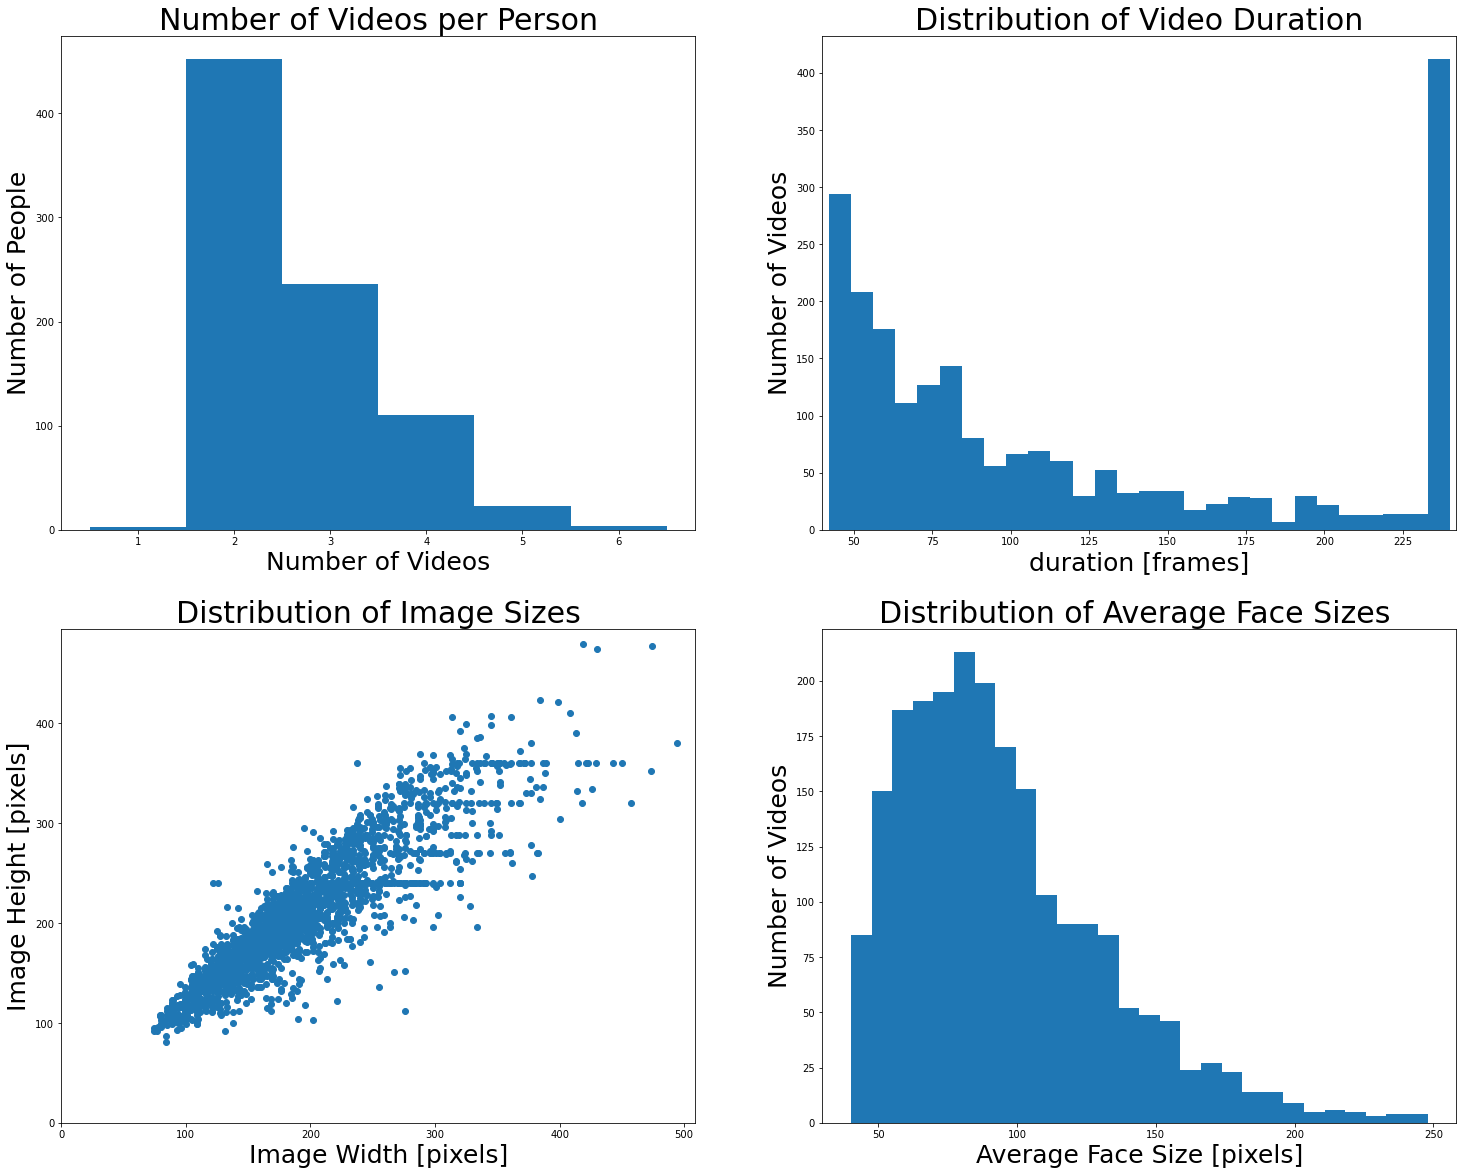

In [7]:
# overview of the contents of the dataset
groupedByPerson = videoDF.groupby("personName")
numVidsPerPerson = groupedByPerson.count()['videoID']
groupedByPerson.count().sort_values('videoID', axis=0, ascending=False)

plt.close('all')
plt.figure(figsize=(25,20))
plt.subplot(2,2,1)
plt.hist(x=numVidsPerPerson,bins=0.5+np.arange(numVidsPerPerson.min()-1,numVidsPerPerson.max()+1))
plt.title('Number of Videos per Person',fontsize=30); 
plt.xlabel('Number of Videos',fontsize=25); plt.ylabel('Number of People',fontsize=25)

plt.subplot(2,2,2)
plt.hist(x=videoDF['videoDuration'],bins=28);
plt.title('Distribution of Video Duration',fontsize=30); 
plt.xlabel('duration [frames]',fontsize=25); plt.ylabel('Number of Videos',fontsize=25)
plt.xlim(videoDF['videoDuration'].min()-2,videoDF['videoDuration'].max()+2)

plt.subplot(2,2,3)
plt.scatter(x=videoDF['imageWidth'], y=videoDF['imageHeight'])
plt.title('Distribution of Image Sizes',fontsize=30)
plt.xlabel('Image Width [pixels]',fontsize=25); plt.ylabel('Image Height [pixels]',fontsize=25)
plt.xlim(0,videoDF['imageWidth'].max() +15)
plt.ylim(0,videoDF['imageHeight'].max()+15)

plt.subplot(2,2,4)
averageFaceSize_withoutNaNs = np.array(videoDF['averageFaceSize'])
averageFaceSize_withoutNaNs = averageFaceSize_withoutNaNs[np.logical_not(np.isnan(averageFaceSize_withoutNaNs))]
plt.hist(averageFaceSize_withoutNaNs, bins=28)
plt.title('Distribution of Average Face Sizes ',fontsize=30)
plt.xlabel('Average Face Size [pixels]',fontsize=25); plt.ylabel('Number of Videos',fontsize=25);

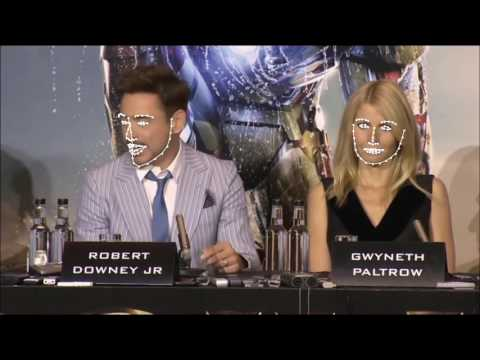

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('8FdSHl4oNIM',width=640, height=480)

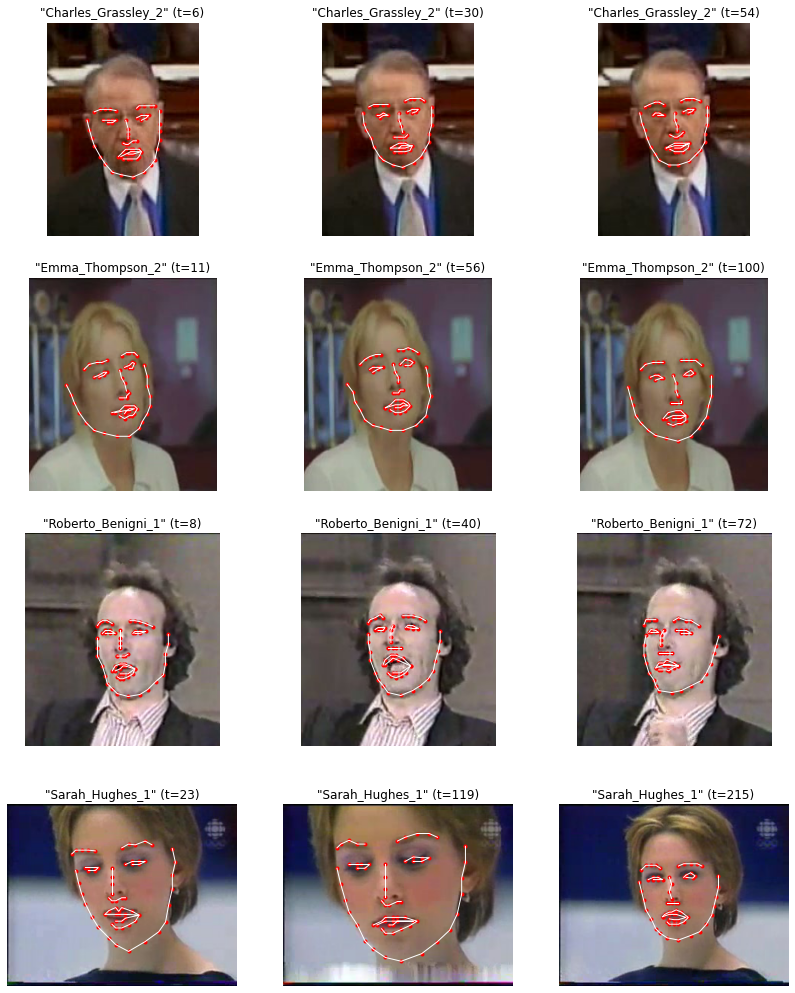

In [10]:
# show several frames from each video and overlay 2D keypoints
np.random.seed(3)
numVideos = 4
framesToShowFromVideo = np.array([0.1,0.5,0.9])
numFramesPerVideo = len(framesToShowFromVideo)

# define which points need to be connected with a line
jawPoints          = [ 0,17]
rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseRidgePoints    = [27,31]
noseBasePoints     = [31,36]
rightEyePoints     = [36,42]
leftEyePoints      = [42,48]
outerMouthPoints   = [48,60]
innerMouthPoints   = [60,68]

listOfAllConnectedPoints = [jawPoints,rigthEyebrowPoints,leftEyebrowPoints,
                            noseRidgePoints,noseBasePoints,
                            rightEyePoints,leftEyePoints,outerMouthPoints,innerMouthPoints]

# select a random subset of 'numVideos' from the available videos
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index,size=numVideos,replace=False),'videoID']

fig, axArray = plt.subplots(nrows=numVideos,ncols=numFramesPerVideo,figsize=(14,18))
for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axArray[i][j].imshow(colorImages[:,:,:,frameInd])
        axArray[i][j].scatter(x=landmarks2D[:,0,frameInd],y=landmarks2D[:,1,frameInd],s=9,c='r')
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks2D[conPts[0]:conPts[-1],0,frameInd]
            yPts = landmarks2D[conPts[0]:conPts[-1],1,frameInd]
            axArray[i][j].plot(xPts,yPts,c='w',lw=1)
        axArray[i][j].set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        axArray[i][j].set_axis_off()

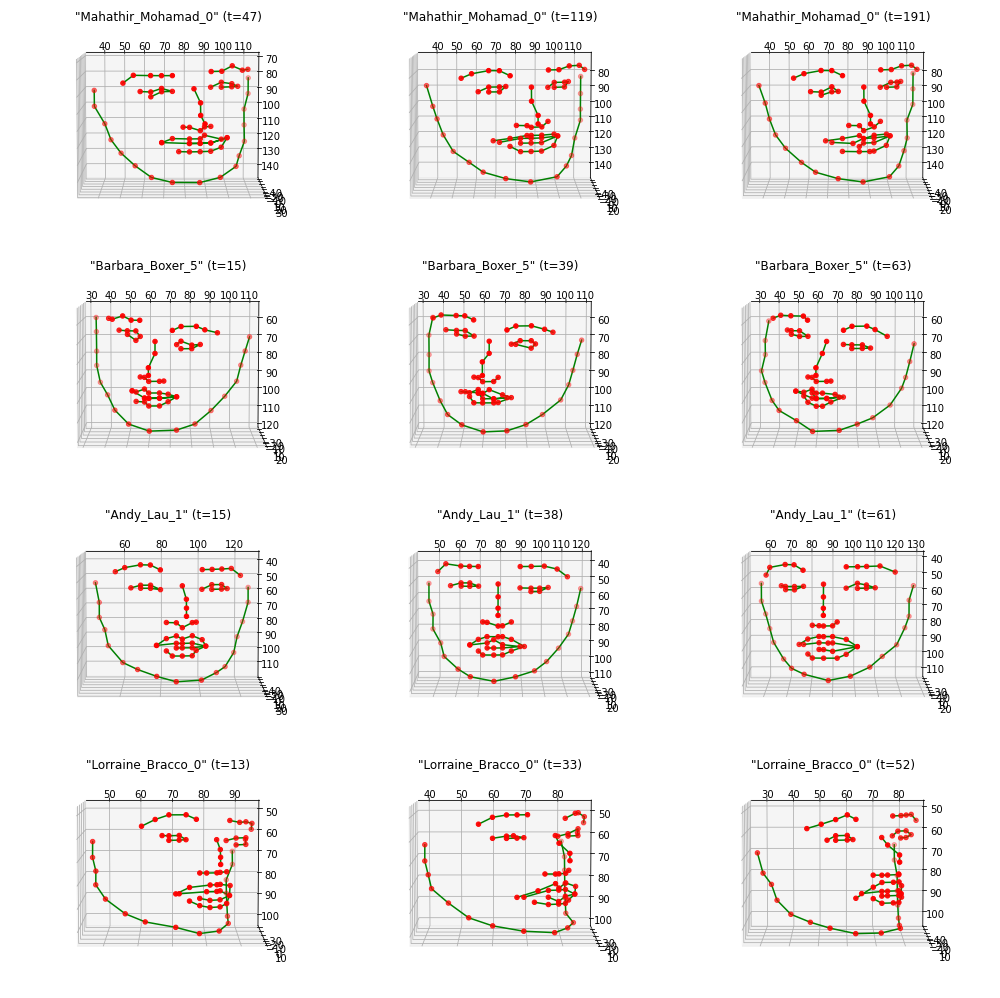

In [11]:
# show several 3D keypoints
numVideos = 4
framesToShowFromVideo = np.array([0.2,0.5,0.8])
numFramesPerVideo = len(framesToShowFromVideo)

# select a random subset of 'numVideos' from the available videos
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index,size=numVideos,replace=False),'videoID']

fig = plt.figure(figsize=(14,14))
for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        subplotInd = i*numFramesPerVideo + j+1
        ax = fig.add_subplot(numVideos, numFramesPerVideo, subplotInd, projection='3d')
        ax.scatter(landmarks3D[:,0,frameInd], landmarks3D[:,1,frameInd], landmarks3D[:,2,frameInd],c='r')
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks3D[conPts[0]:conPts[-1],0,frameInd]
            yPts = landmarks3D[conPts[0]:conPts[-1],1,frameInd]
            zPts = landmarks3D[conPts[0]:conPts[-1],2,frameInd]
            ax.plot3D(xPts,yPts,zPts,color='g')         
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.view_init(elev=96, azim=90)
        ax.set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        
plt.tight_layout()

In [12]:
# collect all 2D and 3D shapes from all frames from all videos to a single numpy array matrix
totalNumberOfFrames = videoDF['videoDuration'].sum()
landmarks2D_all = np.zeros((68,2,int(totalNumberOfFrames)))
landmarks3D_all = np.zeros((68,3,int(totalNumberOfFrames)))

shapeIndToVideoID = {} # dictionary for later useage
endInd = 0
for i, videoID in enumerate(videoDF['videoID']):
    
    # load video
    videoFile = np.load(fullPaths[videoID])
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    startInd = endInd
    endInd   = startInd + landmarks2D.shape[2]

    # store in one big array
    landmarks2D_all[:,:,startInd:endInd] = landmarks2D
    landmarks3D_all[:,:,startInd:endInd] = landmarks3D
    
    # make sure we keep track of the mapping to the original video and frame
    for videoFrameInd, shapeInd in enumerate(range(startInd,endInd)):
        shapeIndToVideoID[shapeInd] = (videoID, videoFrameInd)

# center the shapes around zero
# i.e. such that for each frame the mean x,y,z coordinates will be zero
# or in math terms: Xc = X - mean(X), Yc = Y - mean(Y), Zc = Z - mean(Z)
landmarks2D_centered = np.zeros(landmarks2D_all.shape)
landmarks2D_centered = landmarks2D_all - np.tile(landmarks2D_all.mean(axis=0),[68,1,1])

landmarks3D_centered = np.zeros(landmarks3D_all.shape)
landmarks3D_centered = landmarks3D_all - np.tile(landmarks3D_all.mean(axis=0),[68,1,1])

# normalize the shapes such that they have the same scale
# i.e. such that for each frame the mean euclidian distance from the shape center will be one
# or in math terms: mean( sqrt(dX^2 + dY^2 + dZ^2) ) = 1 
landmarks2D_normlized = np.zeros(landmarks2D_all.shape)
landmarks2D_normlized = landmarks2D_centered / np.tile(np.sqrt((landmarks2D_centered**2).sum(axis=1)).mean(axis=0), [68,2,1])

landmarks3D_normlized = np.zeros(landmarks3D_all.shape)
landmarks3D_normlized = landmarks3D_centered / np.tile(np.sqrt((landmarks3D_centered**2).sum(axis=1)).mean(axis=0), [68,3,1])

Text(0.5, 1.0, 'Normlized Shapes')

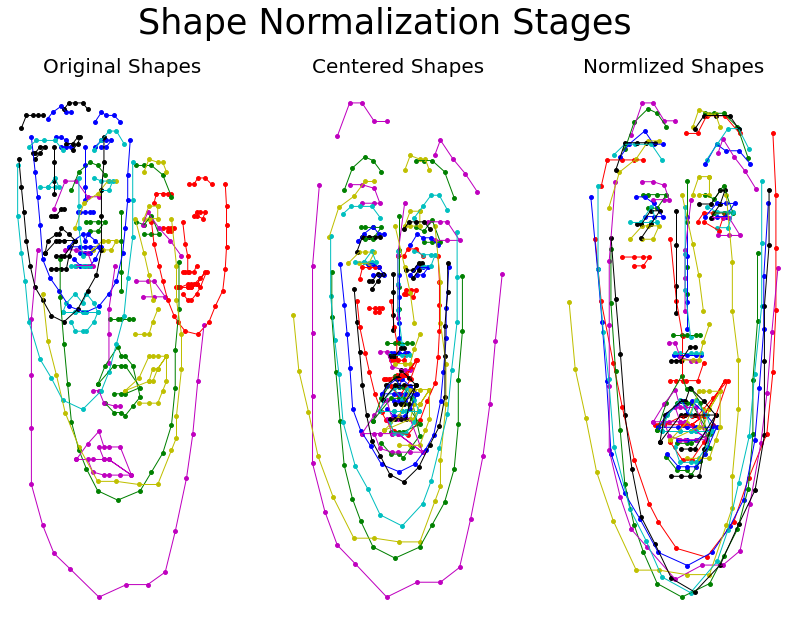

In [13]:
#%% check the 2D normalization and verify that everything is as expected
# select random several frames to be used as test cases
np.random.seed(2)

listOfShapeColors = ['r','g','b','m','y','c','k']
numShapesToPresent = len(listOfShapeColors)
listOfShapeInds = np.random.choice(range(int(totalNumberOfFrames)),size=numShapesToPresent,replace=False)

plt.close('all')
plt.figure(figsize=(14,10))
plt.suptitle('Shape Normalization Stages',fontsize=35)
plt.subplot(1,3,1)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_all[:,0,shapeInd], -landmarks2D_all[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_all[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_all[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Original Shapes', fontsize=20)

plt.subplot(1,3,2)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_centered[:,0,shapeInd], -landmarks2D_centered[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_centered[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_centered[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Centered Shapes', fontsize=20)

plt.subplot(1,3,3)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_normlized[:,0,shapeInd], -landmarks2D_normlized[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_normlized[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_normlized[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Normlized Shapes', fontsize=20)

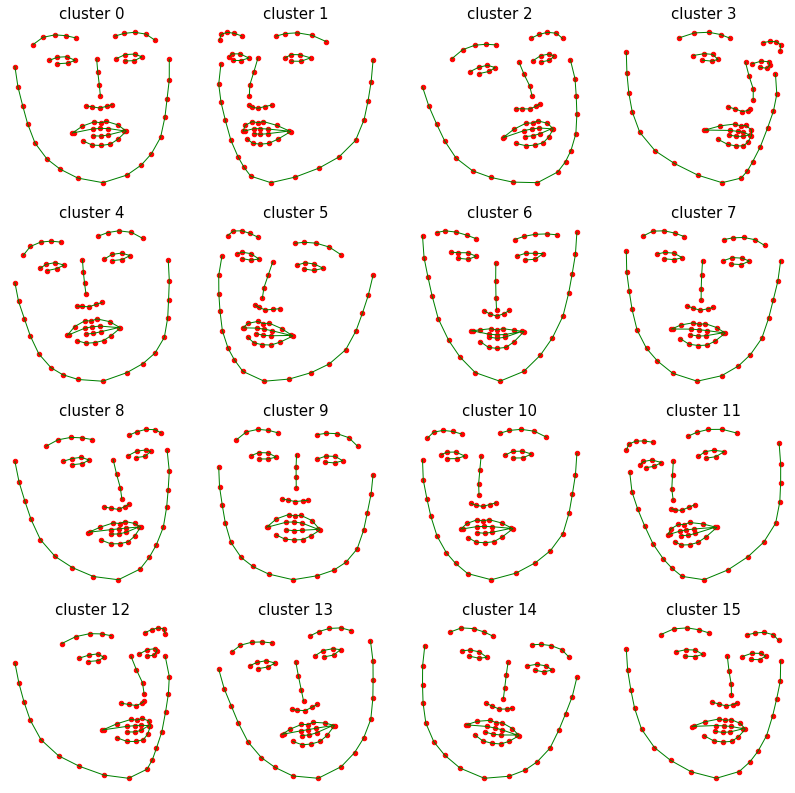

In [14]:
#%% cluster normalized shapes and show the cluster centers
numClusters = 16
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T

shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
clusterAssignment = shapesModel.predict(normalizedShapesTable)

plt.figure(figsize=(14,14))
numRowsAndCols = int(np.ceil(np.sqrt(numClusters)))
for i in range(numClusters):
    plt.subplot(numRowsAndCols,numRowsAndCols,i+1);
    currClusterShape = np.reshape(shapesModel.cluster_centers_[i,:], [68,2])
    plt.scatter(x=currClusterShape[:,0],y=-currClusterShape[:,1],s=20,c='r')
    for conPts in listOfAllConnectedPoints:
        xPts =  currClusterShape[conPts[0]:conPts[-1],0]
        yPts = -currClusterShape[conPts[0]:conPts[-1],1]
        plt.plot(xPts,yPts,c='g',lw=1)
    plt.title('cluster %d' %(i),fontsize=15)
    plt.axis('off')

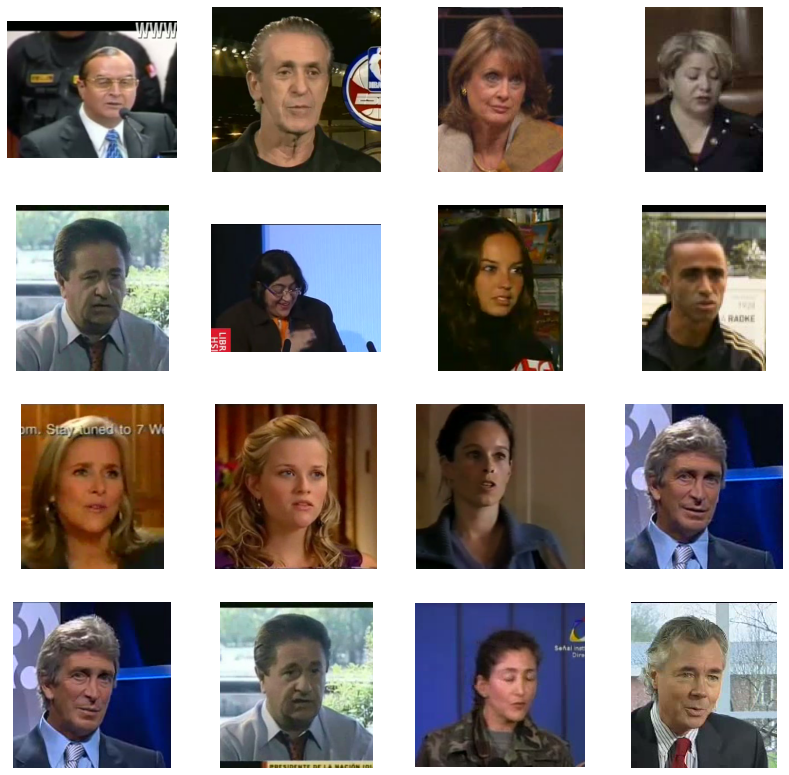

In [15]:
selectedCluster = 15
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

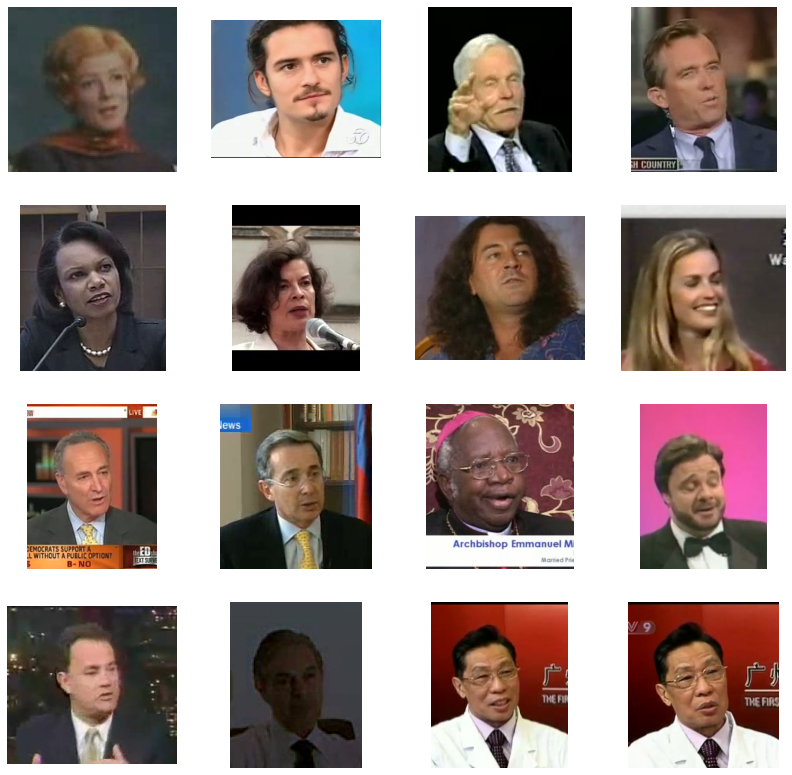

In [16]:
selectedCluster = 2
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

In [17]:
# warp image with a picewise affine transform
def warp_im_picewise_affine(src_im, src_coords, dst_coords, target_im_size=None):
    """warped_im = warp_im_picewise_affine(src_im, src_coords, dst_coords, target_im_size)"""
    requested_transfromation = tf.estimate_transform('piecewise-affine',src_coords,dst_coords)
    warped_im = tf.warp(src_im,requested_transfromation.inverse,output_shape=target_im_size)
    return warped_im

In [18]:
#%% take a random frontal face image and warp it's texture into all kmeans shapes to demonstrate picewise affine warping
np.random.seed(1)

# get shape ids only of large faces
large_faces_videoIDs = videoDF.loc[videoDF['averageFaceSize'] > 80, 'videoID'].tolist()
shape_ind_large_face_only = []
for key, value in shape_ind_to_videoID_map.items():
    if value[0] in large_faces_videoIDs:
        shape_ind_large_face_only.append(key)
shape_ind_large_face_only = np.array(shape_ind_large_face_only)
        
overlay_landmarks = False
frontal_shape_cluster_ind = 16
frontal_inds = np.nonzero(cluster_assignment == frontal_shape_cluster_ind)[0]
frontal_inds = np.array(list(set(frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_ind = np.random.choice(frontal_inds,size=1)[0]

selected_videoID = shape_ind_to_videoID_map[some_frontal_image_ind][0]
selected_video_frame = shape_ind_to_videoID_map[some_frontal_image_ind][1]

video_file = np.load(full_paths[selected_videoID])
selected_frontal_image = video_file['colorImages'][:,:,:,selected_video_frame]
selected_frontal_shape = video_file['landmarks2D'][:,:,selected_video_frame]

#plt.figure(); plt.imshow(selected_frontal_image); plt.scatter(selected_frontal_shape[:,0],selected_frontal_shape[:,1])

plt.close('all')
fig, ax = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(16,9))
for i in range(num_clusters):
    curr_landmarks2D_norm = np.reshape(ShapesKmeansModel.cluster_centers_[i,:], [NUM_LANDMARKS,NUM_DIMS])
    
    # project the shape and reconstruct using the PCA model (to correct small shape jitter)
    curr_landmarks2D_norm_rec = ShapesPCAModel.transform(curr_landmarks2D_norm.reshape([1,NUM_LANDMARKS*NUM_DIMS]))
    curr_landmarks2D_norm_rec = ShapesPCAModel.inverse_transform(curr_landmarks2D_norm_rec)
    curr_landmarks2D_norm_rec = curr_landmarks2D_norm_rec.reshape([NUM_LANDMARKS,NUM_DIMS])
    
    # tranform to image coordinates
    curr_landmarks2D =  50 * curr_landmarks2D_norm_rec
    curr_landmarks2D += 100
    
    if i == frontal_shape_cluster_ind:
        # when the desired cluster is frontal, just show the original image
        ax[i % num_rows, i // num_rows].imshow(selected_frontal_image)
        ax[i % num_rows, i // num_rows].set_title('original image')
    else:
        # else, warp the image to the desired cluster
        warped_im = warp_im_picewise_affine(selected_frontal_image, selected_frontal_shape, curr_landmarks2D, target_im_size=[200,200])
        ax[i % num_rows, i // num_rows].imshow(warped_im)
        ax[i % num_rows, i // num_rows].set_title('cluster %d' %(i))
        
        # show the landmarks
        if overlay_landmarks:
            ax[i % num_rows, i // num_rows].scatter(curr_landmarks2D[:,0], curr_landmarks2D[:,1], c='r', s=1.3)
            for conPts in list_of_connected_points:
                xPts = curr_landmarks2D[conPts,0]
                yPts = curr_landmarks2D[conPts,1]
                ax[i % num_rows, i // num_rows].plot(xPts,yPts,color='g',linewidth=0.6)
    
    ax[i % num_rows,i // num_rows].set_axis_off()
fig.tight_layout()
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.05)

NameError: name 'shape_ind_to_videoID_map' is not defined